# EmptyDrops Validation: R vs Python Implementation

This notebook validates our Python implementation of EmptyDrops against the original R implementation from DropletUtils.

## Overview
- Load the same raw data in both R and Python
- Run EmptyDrops with identical parameters
- Compare results: p-values, FDR, identified cells
- Generate validation plots and statistics

## Parameters Used
Based on the original EmptyDrops R function documentation:
- `lower=100`: Lower bound for empty droplets
- `retain=NULL`: Automatically determined from barcodeRanks knee point
- `niters=10000`: Number of Monte Carlo iterations
- `alpha=Inf`: Multinomial (not Dirichlet-multinomial) distribution
- `test.ambient=FALSE`: Don't test ambient droplets
- `ignore=NULL`: No additional filtering
- `by.rank=NULL`: Use total count threshold, not rank-based
- `known.empty=NULL`: Automatically identify empty droplets


## R Implementation

First, let's run the original EmptyDrops function from DropletUtils.


In [2]:
# Load required libraries
library(DropletUtils)
library(Matrix)
library(scater)

# Load raw data
raw_counts <- read10xCounts("raw_feature_bc_matrix.h5")
cat("Raw matrix dimensions:", dim(raw_counts), "\n")

# R doesnt only load GEX data (as i did in python -> 22040 genes) but other data too resulting in total of 74000 genes
# this means we are getting more cells with total UMI > lower, resulting in more cells being tested
# this is why R found over 33k cells and python found only 15k as non-empty

gex_mask <- rowData(raw_counts)$Type == "Gene Expression"
raw_matrix <- counts(raw_counts)[gex_mask, ]
# Get the count matrix
#raw_matrix <- counts(raw_counts)

# check if GEX filtering worked
cat("Number of genes after GEX filtering:", nrow(raw_matrix), "\n")

# Show some basic statistics
total_counts <- colSums(raw_matrix)
cat("Total cells with more than 100 UMI:", sum(total_counts > 100), "\n")

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

Raw matrix dimensions: 61313 722431 
Number of genes after GEX filtering: 22040 
Total cells with more than 100 UMI: 15000 


In [3]:
# print type of raw_matrix
cat("Type of raw_matrix:", typeof(raw_matrix), "\n")
# print all availabe columns for the S4 class
raw_matrix

Type of raw_matrix: S4 


<22040 x 722431> sparse DelayedMatrix object of type "integer":
                        [,1]      [,2]      [,3]      [,4] ... [,722428]
ENSSSCG00000028996         0         0         0         0   .         0
ENSSSCG00000005267         0         0         0         0   .         0
ENSSSCG00000005268         0         0         0         0   .         0
ENSSSCG00000005269         0         0         0         0   .         0
ENSSSCG00000031382         0         0         0         0   .         0
               ...         .         .         .         .   .         .
ENSSSCG00000018087         0         0         0         0   .         0
ENSSSCG00000018091         0         0         0         0   .         0
ENSSSCG00000018092         0         0         0         0   .         0
ENSSSCG00000018094         0         0         0         0   .         0
ENSSSCG00000034846         0         0         0         0   .         0
                   [,722429] [,722430] [,722431]
ENSSSCG0000

In [4]:
# Convert DelayedMatrix to dgCMatrix for compatibility
cat("Converting DelayedMatrix to dgCMatrix...\n")
raw_matrix <- as(raw_matrix, "dgCMatrix")
cat("Type of raw_matrix after conversion:", class(raw_matrix), "\n")
cat("Matrix dimensions:", dim(raw_matrix), "\n")

Converting DelayedMatrix to dgCMatrix...
Type of raw_matrix after conversion: dgCMatrix 
Matrix dimensions: 22040 722431 


In [5]:
raw_matrix

# count the count of entries >0 in the raw matrix
non_zero_count <- length(raw_matrix@x)
print(paste("Number of non-zero entries:", non_zero_count))

22040 x 722431 sparse Matrix of class "dgCMatrix"
                                                                                         
ENSSSCG00000028996 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
ENSSSCG00000005267 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
ENSSSCG00000005268 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
ENSSSCG00000005269 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
ENSSSCG00000031382 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
ENSSSCG00000005271 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
ENSSSCG00000005272 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
ENSSSCG00000005273 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
ENSSSCG00000045514 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
ENSSSCG00000023520 . . . . . . . . . . . . . . . .

[1] "Number of non-zero entries: 18590407"


In [26]:
# Run EmptyDrops with documented default parameters
cat("Running EmptyDrops R implementation...\n")
system.time({
    r_results <- emptyDrops(
        m = raw_matrix,
        lower = 100,           # Lower bound for empty droplets
        retain = NULL,         # Auto-determine from barcodeRanks
        niters = 10000,        # Monte Carlo iterations
        test.ambient = FALSE,  # Don't test ambient droplets
        ignore = NULL,         # No additional filtering
        alpha = Inf,           # Multinomial distribution
        round = TRUE,          # Round non-integer counts
        by.rank = NULL         # Use count threshold, not rank
    )
})

# Display results summary
cat("\nR Results Summary:\n")
print(summary(r_results))

# Get metadata
r_metadata <- metadata(r_results)
cat("\nR Metadata:\n")
cat("Lower threshold:", r_metadata$lower, "\n")
cat("Retain threshold:", r_metadata$retain, "\n")
cat("Alpha parameter:", r_metadata$alpha, "\n")
cat("Number of iterations:", r_metadata$niters, "\n")

Running EmptyDrops R implementation...


   user  system elapsed 
 29.751   0.462  30.581 


R Results Summary:
[1] "DataFrame object of length 5 with 0 metadata columns"

R Metadata:
Lower threshold: 100 
Retain threshold: 10754 
Alpha parameter: Inf 
Number of iterations: 10000 


In [24]:
# Analyze R results
# Count significant cells at different FDR thresholds
fdr_001 <- sum(r_results$FDR <= 0.001, na.rm = TRUE)
fdr_01 <- sum(r_results$FDR <= 0.01, na.rm = TRUE)
fdr_05 <- sum(r_results$FDR <= 0.05, na.rm = TRUE)

cat("R Implementation - Significant cells:\n")
cat("FDR <= 0.001:", fdr_001, "\n")
cat("FDR <= 0.01: ", fdr_01, "\n")
cat("FDR <= 0.05: ", fdr_05, "\n")

# Count non-NA results (tested barcodes)
tested_barcodes <- sum(!is.na(r_results$PValue))
cat("Tested barcodes:", tested_barcodes, "\n")

# Show distribution of p-values
valid_pvals <- r_results$PValue[!is.na(r_results$PValue)]
cat("P-value distribution:\n")
print(summary(valid_pvals))

# Save R results in multiple formats for robustness and further analysis
cat("\nSaving R results...\n")

# Generate unique timestamp for file naming
timestamp <- format(Sys.time(), "%d%m%Y%H%M")
cat("Using timestamp:", timestamp, "\n")

# 1. Save as CSV with barcode names as row names (standard format)
write.csv(r_results, paste0("emptydrops_runR/", timestamp, "_validation_r_emptydrops_results.csv"), row.names = TRUE)

# 2. Save as RDS for exact R object preservation
saveRDS(r_results, paste0("emptydrops_runR/", timestamp, "_validation_r_emptydrops_results.rds"))

# 3. Save metadata separately
r_meta <- metadata(r_results)

# Handle different metadata types properly
meta_scalars <- r_meta[sapply(r_meta, function(x) length(x) == 1)]
meta_vectors <- r_meta[sapply(r_meta, function(x) length(x) > 1)]

# Save scalar metadata
if(length(meta_scalars) > 0) {
    scalar_df <- data.frame(
        parameter = names(meta_scalars),
        value = sapply(meta_scalars, function(x) if(is.null(x)) "NULL" else as.character(x)),
        stringsAsFactors = FALSE
    )
    write.csv(scalar_df, paste0("emptydrops_runR/", timestamp, "_validation_r_metadata.csv"), row.names = FALSE)
}

# Save vector metadata separately (like ambient profile)
if(length(meta_vectors) > 0) {
    for(param_name in names(meta_vectors)) {
        write.csv(data.frame(
            gene_index = seq_along(meta_vectors[[param_name]]),
            value = meta_vectors[[param_name]]
        ), paste0("emptydrops_runR/", timestamp, "_validation_r_", param_name, ".csv"), row.names = FALSE)
    }
}

# 4. Save summary statistics
r_summary_stats <- data.frame(
    metric = c("total_barcodes", "tested_barcodes", "cells_fdr_0.001", "cells_fdr_0.01", "cells_fdr_0.05"),
    value = c(
        nrow(r_results),
        sum(!is.na(r_results$PValue)),
        sum(r_results$FDR <= 0.001, na.rm = TRUE),
        sum(r_results$FDR <= 0.01, na.rm = TRUE),
        sum(r_results$FDR <= 0.05, na.rm = TRUE)
    )
)
write.csv(r_summary_stats, paste0("emptydrops_runR/", timestamp, "_validation_r_summary_stats.csv"), row.names = FALSE)

cat("R results saved to emptydrops_runR/ with timestamp", timestamp, ":\n")
cat("  -", paste0(timestamp, "_validation_r_emptydrops_results.csv"), "(main results)\n")
cat("  -", paste0(timestamp, "_validation_r_emptydrops_results.rds"), "(R object)\n") 
cat("  -", paste0(timestamp, "_validation_r_metadata.csv"), "(scalar parameters)\n")
if(length(meta_vectors) > 0) {
    for(param_name in names(meta_vectors)) {
        cat("  -", paste0(timestamp, "_validation_r_", param_name, ".csv"), "(", param_name, " vector)\n", sep="")
    }
}
cat("  -", paste0(timestamp, "_validation_r_summary_stats.csv"), "(summary)\n")


R Implementation - Significant cells:
FDR <= 0.001: 6892 
FDR <= 0.01:  7505 
FDR <= 0.05:  8182 
Tested barcodes: 15000 
P-value distribution:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
9.999e-05 9.999e-05 4.999e-03 2.672e-01 5.514e-01 1.000e+00 

Saving R results...
Using timestamp: 231020251056 
R results saved to emptydrops_runR/ with timestamp 231020251056 :
  - 231020251056_validation_r_emptydrops_results.csv (main results)
  - 231020251056_validation_r_emptydrops_results.rds (R object)
  - 231020251056_validation_r_metadata.csv (scalar parameters)
  -231020251056_validation_r_ambient.csv(ambient vector)
  - 231020251056_validation_r_summary_stats.csv (summary)


# PYTHON

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from empty_drops import empty_drops
import time
import warnings
warnings.filterwarnings('ignore')

# Data loading utility functions for robust analysis
def load_validation_results():
    """
    Load both R and Python EmptyDrops results with fallback options.
    Returns a dictionary with the loaded data and metadata.
    """
    results = {
        'r_results': None,
        'python_results': None,
        'r_metadata': None,
        'python_metadata': None,
        'r_summary': None,
        'python_summary': None,
        'comparison_data': None
    }
    
    # Load R results
    r_files = [
        'emptydrops_runR/validation_r_emptydrops_results.csv',
        'emptydrops_runR/r_emptydrops_results.csv',  # fallback
        'emptydrops_runR/empty_drops_results.csv'    # another fallback
    ]
    
    for r_file in r_files:
        try:
            results['r_results'] = pd.read_csv(r_file, index_col=0)
            print(f"✓ Loaded R results from: {r_file}")
            break
        except FileNotFoundError:
            continue
    
    if results['r_results'] is None:
        print("⚠️  No R results found")
    
    # Load Python results
    py_files = [
        'validation_python_emptydrops_results.csv',
        'python_emptydrops_results.csv',  # fallback
        'empty_drops_results.csv'         # another fallback
    ]
    
    for py_file in py_files:
        try:
            results['python_results'] = pd.read_csv(py_file, index_col=0)
            print(f"✓ Loaded Python results from: {py_file}")
            break
        except FileNotFoundError:
            continue
    
    if results['python_results'] is None:
        print("⚠️  No Python results found")
    
    # Load metadata files if available
    try:
        results['r_metadata'] = pd.read_csv('validation_r_metadata.csv')
        print("✓ Loaded R metadata")
        
        # Try to load ambient profile if available
        try:
            results['r_ambient'] = pd.read_csv('validation_r_ambient.csv')
            print("✓ Loaded R ambient profile")
        except FileNotFoundError:
            pass
            
    except FileNotFoundError:
        print("⚠️  R metadata not found")
    
    try:
        results['python_metadata'] = pd.read_csv('validation_python_metadata.csv')
        print("✓ Loaded Python metadata")
    except FileNotFoundError:
        print("⚠️  Python metadata not found")
    
    # Load summary statistics if available
    try:
        results['r_summary'] = pd.read_csv('validation_r_summary_stats.csv')
        print("✓ Loaded R summary statistics")
    except FileNotFoundError:
        print("⚠️  R summary statistics not found")
    
    try:
        results['python_summary'] = pd.read_csv('validation_python_summary_stats.csv')
        print("✓ Loaded Python summary statistics")
    except FileNotFoundError:
        print("⚠️  Python summary statistics not found")
    
    # Load previous comparison results if available
    try:
        results['comparison_data'] = pd.read_csv('comparison_summary.csv')
        print("✓ Loaded previous comparison data")
    except FileNotFoundError:
        print("⚠️  No previous comparison data found")
    
    return results

# Test the loading function
print("Testing data loading utility:")
loaded_data = load_validation_results()


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Testing data loading utility:
✓ Loaded R results from: emptydrops_runR/validation_r_emptydrops_results.csv
✓ Loaded Python results from: empty_drops_results.csv
✓ Loaded R metadata
✓ Loaded R ambient profile
⚠️  Python metadata not found
✓ Loaded R summary statistics
⚠️  Python summary statistics not found
✓ Loaded previous comparison data


## Python Implementation

Now let's run our Python implementation with equivalent parameters.


In [ ]:
# Import required libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from empty_drops import empty_drops
import time
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries loaded successfully")

Libraries loaded successfully


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading raw data in Python...
Raw matrix dimensions: (722431, 22040)
Number of genes: 22040
Number of barcodes: 722431
Total UMI counts per barcode - Min: 0.0, Max: 255392.0


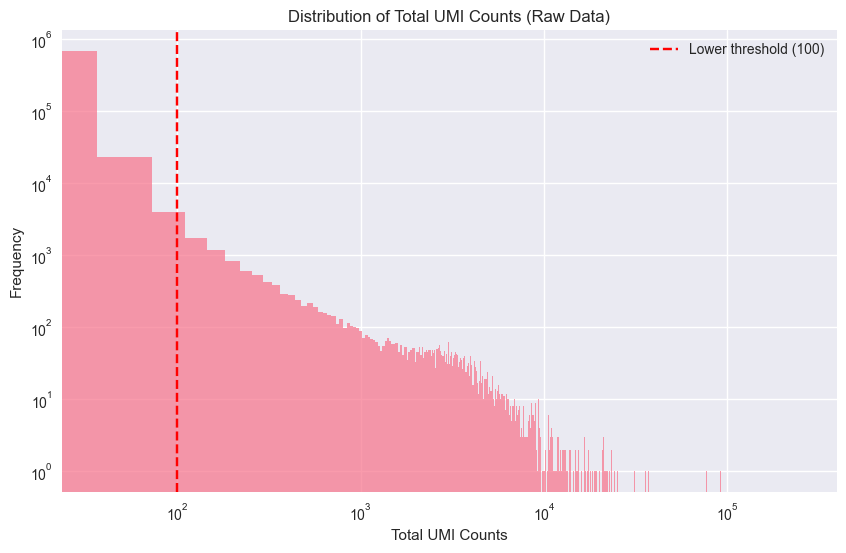

In [ ]:
# Load raw data in Python
print("Loading raw data in Python...")
raw_adata = sc.read_10x_h5('raw_feature_bc_matrix.h5')

# Make variable names unique (R does this automatically)
raw_adata.var_names_make_unique()

print(f"Raw matrix dimensions: {raw_adata.shape}")
print(f"Number of genes: {raw_adata.n_vars}")
print(f"Number of barcodes: {raw_adata.n_obs}")

# Calculate basic statistics
total_counts = raw_adata.X.sum(axis=1).A1
print(f"Total UMI counts per barcode - Min: {total_counts.min()}, Max: {total_counts.max()}")

# Show distribution of total counts
plt.figure(figsize=(10, 6))
plt.hist(total_counts, bins=7000, alpha=0.7, log=True)
plt.xlabel('Total UMI Counts')
plt.ylabel('Frequency')
plt.title('Distribution of Total UMI Counts (Raw Data)')
plt.axvline(x=100, color='r', linestyle='--', label='Lower threshold (100)')
plt.xscale('log')
plt.legend()
plt.show()


In [ ]:
# Run Python EmptyDrops with parameters matching R implementation
print("Running Python EmptyDrops implementation...")
start_time = time.time()

#clear the cache
import shutil
shutil.rmtree('empty_drops_cache', ignore_errors=True)

# Parameters matching R defaults
py_results = empty_drops(
    data=raw_adata,
    lower=100,             # Lower bound for empty droplets
    retain=None,           # Auto-determine (Python will calculate knee point)
    test_ambient=False,    # Don't test ambient droplets  
    niters=50,          # Monte Carlo iterations niters=10k=460minutes / 
    ignore=None,           # No additional filtering
    alpha=np.inf,          # Multinomial distribution (infinite alpha)
    round=True,            # Round non-integer counts
    by_rank=None,          # Use count threshold, not rank
    known_empty=None,      # Automatically identify empty droplets
    progress=True,         # Show progress
    adaptive=False,        # Use fixed iterations for comparison
    min_iters=10000,       # Fixed iterations
    max_iters=10000,       # Fixed iterations
    early_stopping=False,  # Don't stop early for exact comparison
    use_cache=False,       # Don't use cache for fresh run
    visualize=True,        # Skip visualizations for now
    dataset_name="slowEDv2",
    n_processes=1          # 0 = auto, uses all CPUs that are available
    #multiprocessing used the whole CPU but wasnt really faster, seems to be a bugö+++ä.
)

python_time = time.time() - start_time
print(f"\nPython analysis completed in {python_time:.2f} seconds")

Running Python EmptyDrops implementation...
Starting EmptyDrops analysis...
Output directory: emptydrops_runs/betterEDv1/20251023_100034_run
Filtering genes...
2014 genes filtered out since sum(counts) over the gene was 0.
Calculating total counts per barcode...
Data shape: (722431, 20026) (n_obs=722431, n_vars=20026)
Total counts distribution plot saved to 'emptydrops_runs/betterEDv1/20251023_100034_run/visualizations/total_counts_distribution.png'
Calculating knee point for retain threshold...
Knee point plot saved to 'emptydrops_runs/betterEDv1/20251023_100034_run/visualizations/knee_point.png'
Calculated retain threshold (knee point): 8128.0
Identifying empty droplets...
Identified 707431 empty droplets out of 722431 total droplets (97.92%)
Empty droplet threshold plot saved to 'emptydrops_runs/betterEDv1/20251023_100034_run/visualizations/empty_droplet_threshold.png'
Calculating ambient profile...
Ambient profile plot saved to 'emptydrops_runs/betterEDv1/20251023_100034_run/visual

Monte Carlo simulation: 100%|██████████| 50/50 iterations [05:07<00:00,  6.14s/it]


Calculating p-values...
  n_above statistics: min=0, max=12, mean=0.00
  Cells where ALL 50 simulations were more extreme: 0.0%
  Cells where NO simulations were more extreme: 100.0%
  ⚠️  WARNING: >20% cells have no extreme simulations - likely very different from ambient (good!)
  Number of cells with n_above=0: 14994
  Number of cells with n_above=50: 0
  P-value statistics: min=0.019608, max=0.254902, mean=0.019644
  P-values = 0.019608 (minimum possible): 14994
Set PValue=0 for 790 high-count droplets (>= 8128.0) before FDR correction
Barcode ranks and knee detection plot saved to 'emptydrops_runs/betterEDv1/20251023_100034_run/visualizations/barcode_ranks_knee_detection.png'

=== Significance Summary ===
Cells with FDR <= 0.001: 790
Cells with FDR <= 0.01:  790
Cells with FDR <= 0.05:  14996
Cells with FDR > 0.05:   4

=== P-value Distribution ===
Min p-value: 0.000000
Max p-value: 0.254902
Mean p-value: 0.018612
Median p-value: 0.019608
P-values == 0: 790
P-values < 0.001: 790
P

## knee point

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
raw_adata = sc.read_10x_h5('raw_feature_bc_matrix.h5')
print("raw_adata shape: ", raw_adata.X.shape)
# length of var names
print("length of var names: ", len(raw_adata.var_names))
print("lenght of obs names: ", len(raw_adata.obs_names))
# Calculate total UMI counts per barcode
lower = 100
tb = raw_adata.X.sum(axis=1).A1 
print("total_counts length: ", tb.shape)
tb = tb[tb > lower]
print("tb length after lower: ", tb.shape)
print(f"First 20 total counts: {tb[0:20]}")

# Rank all barcodes in order of decreasing total UMI count
tb = np.sort(np.asarray(tb))[::-1]
print(f"First 20 sorted total counts: {tb[0:20]}")

# Calculate ranks (1-based)
ranks = np.arange(1, len(tb) + 1)

# Calculate log-transformed values
x = np.log10(ranks)
y = np.log10(tb + 1e-8)  # avoid log(0)

print(f"First 20 log total counts: {y[0:20]}")
print(f"First 20 log ranks: {x[0:20]}")


raw_adata shape:  (722431, 22040)
length of var names:  22040
lenght of obs names:  722431
total_counts length:  (722431,)
tb length after lower:  (15000,)
First 20 total counts: [  134. 11029.   256.  1100.   555.  5911.   788.   516.  4561.   219.
   145.   554.   117.   332.  3048.  3487.   339.  3596.   249.  1465.]
First 20 sorted total counts: [255392. 123383. 113387.  92017.  77196.  70265.  69509.  69132.  68681.
  64868.  63580.  58694.  54547.  50809.  50280.  47444.  47397.  46875.
  44110.  41376.]
First 20 log total counts: [5.4072075 5.091255  5.054563  4.963868  4.8875947 4.846739  4.842041
 4.8396792 4.836837  4.8120303 4.8033204 4.768594  4.736771  4.7059407
 4.701395  4.6761813 4.6757507 4.6709414 4.644537  4.6167483]
First 20 log ranks: [0.         0.30103    0.47712125 0.60205999 0.69897    0.77815125
 0.84509804 0.90308999 0.95424251 1.         1.04139269 1.07918125
 1.11394335 1.14612804 1.17609126 1.20411998 1.23044892 1.25527251
 1.2787536  1.30103   ]


knee_idx:  789


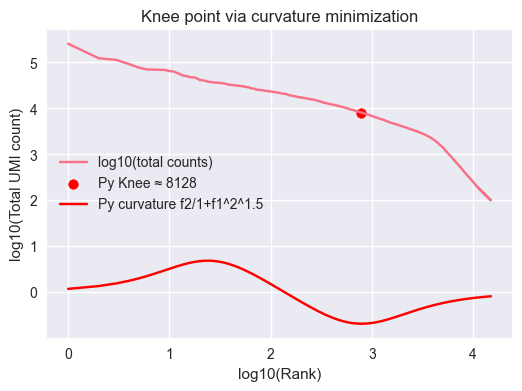

knee rank:  789
total counts at knee rank:  8128.0
knee x:  2.8976270912904414
knee y:  3.9099836


In [ ]:
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(x, y, k=3, s=1e5) # s = smoothing factor
f1 = spline.derivative(n=1)(x) #erste ableitung
f2 = spline.derivative(n=2)(x) # zwote  
curvature = f2 / (1 + f1**2)**1.5 #signed curvature
# Minimum (most negative curvature)
knee_idx = np.argmin(curvature) - 1 # da 0 basiert
print("knee_idx: ", knee_idx)
knee_x = x[knee_idx]
knee_y = y[knee_idx]
knee_count = tb[knee_idx]#10 ** knee_y
plt.figure(figsize=(6,4))
plt.plot(x, y, label='log10(total counts)')
plt.scatter(knee_x, knee_y, color='red', label=f'Py Knee ≈ {knee_count:.0f}')
r_knee = 400
#plt.scatter(x[r_knee], y[r_knee], color='blue', label=f'R Knee ≈ {tb[r_knee]:.0f}')
plt.plot(x, curvature, color='red', label='Py curvature f2/1+f1^2^1.5')
plt.xlabel("log10(Rank)")
plt.ylabel("log10(Total UMI count)")
plt.title("Knee point via curvature minimization")
plt.legend()
plt.show()
print("knee rank: ", knee_idx)
print("total counts at knee rank: ", knee_count)
print("knee x: ", knee_x)
print("knee y: ", knee_y)

Deine bisherige Methode (Abstandsmaximum) misst die Abweichung von einer Linie zwischen den Endpunkten – das funktioniert gut bei glatten Übergängen, aber versagt bei sehr steilen oder nahezu linearen Bereichen (wie du gesehen hast).
Die Krümmungsbasierte Methode hier dagegen:
nutzt lokale Ableitungen 
f
′
,
f
′
′
f 
′
 ,f 
′′
ist unabhängig von der globalen Steilheit der Kurve
identifiziert exakt die Stelle, wo sich die Krümmung ändert – also die geometrische Definition eines „Knickpunkts“.

In [ ]:
import pyarrow
import fastparquet

# Analyze Python results
print("Python Results Summary:")
# test if pyresults is in the jupyter variables
if 'py_results' in locals():
    print(py_results.describe())

# Count significant cells at different FDR thresholds
fdr_001_py = (py_results['FDR'] <= 0.001).sum()
fdr_01_py = (py_results['FDR'] <= 0.01).sum()
fdr_05_py = (py_results['FDR'] <= 0.05).sum()

print("\nPython Implementation - Significant cells:")
print(f"FDR <= 0.001: {fdr_001_py}")
print(f"FDR <= 0.01:  {fdr_01_py}")
print(f"FDR <= 0.05:  {fdr_05_py}")

# Count tested barcodes (non-NA p-values)
tested_barcodes_py = py_results['PValue'].notna().sum()
print(f"Tested barcodes: {tested_barcodes_py}")

# Show distribution of p-values
valid_pvals_py = py_results['PValue'].dropna()
print("\nP-value distribution:")
print(valid_pvals_py.describe())

# Save Python results in multiple formats for robustness and further analysis
print("\nSaving Python results...")

# 1. Save as CSV (standard format)
py_results.to_csv('validation_python_emptydrops_results.csv')

# 2. Save as Parquet for efficient storage and fast loading (optional)
try:
    try:
        py_results.to_parquet('validation_python_emptydrops_results.parquet')
        parquet_saved = True
        print('  ✓ Saved Parquet format')
    except (ImportError, Exception) as e:
        # Handle ImportError (missing libraries) and ArrowKeyError (version conflicts)
        if 'ArrowKeyError' in str(type(e)) or 'pandas.period' in str(e):
            print('  ⚠️  Parquet saving failed (pandas/pyarrow version conflict)')
            print('      Try: pip install --upgrade pandas pyarrow')
        elif 'ImportError' in str(type(e)):
            print('  ⚠️  Parquet saving skipped (missing pyarrow/fastparquet)')
            print('      Install with: pip install pyarrow')
        else:
            print(f'  ⚠️  Parquet saving failed: {str(e)}')
        parquet_saved = False
    parquet_saved = True
    print('  ✓ Saved Parquet format')
except ImportError:
    print('  ⚠️  Parquet saving skipped (missing pyarrow/fastparquet)')
    print('      Install with: pip install pyarrow')
    parquet_saved = False

# 3. Save as pickle for exact Python object preservation
py_results.to_pickle('validation_python_emptydrops_results.pkl')

# 4. Save metadata/parameters used
py_metadata = {
    'lower': 100,
    'retain': None,
    'test_ambient': False,
    'niters': 500,
    'ignore': None,
    'alpha': np.inf,
    'round': True,
    'by_rank': None,
    'known_empty': None,
    'adaptive': False,
    'min_iters': 10000,
    'max_iters': 10000,
    'early_stopping': False,
    'data_shape': raw_adata.shape,
    'total_genes': raw_adata.n_vars,
    'total_barcodes': raw_adata.n_obs
}

py_metadata_df = pd.DataFrame([
    {'parameter': k, 'value': str(v)} for k, v in py_metadata.items()
])
py_metadata_df.to_csv('validation_python_metadata.csv', index=False)

# 5. Save summary statistics
py_summary_stats = pd.DataFrame([
    {'metric': 'total_barcodes', 'value': len(py_results)},
    {'metric': 'tested_barcodes', 'value': py_results['PValue'].notna().sum()},
    {'metric': 'cells_fdr_0.001', 'value': (py_results['FDR'] <= 0.001).sum()},
    {'metric': 'cells_fdr_0.01', 'value': (py_results['FDR'] <= 0.01).sum()},
    {'metric': 'cells_fdr_0.05', 'value': (py_results['FDR'] <= 0.05).sum()}
])
py_summary_stats.to_csv('validation_python_summary_stats.csv', index=False)

print("Python results saved to:")
print("  - validation_python_emptydrops_results.csv (main results)")
if parquet_saved:
    if parquet_saved:
        print("  - validation_python_emptydrops_results.parquet (efficient format)")
print("  - validation_python_emptydrops_results.pkl (Python object)")
print("  - validation_python_metadata.csv (parameters)")
print("  - validation_python_summary_stats.csv (summary)")


Python Results Summary:
               Total        LogProb        PValue           FDR
count  722431.000000   15000.000000  15000.000000  15000.000000
mean       48.798923   -6455.715728      0.000138      0.000138
std       753.944092   10176.294443      0.003128      0.003128
min         0.000000 -417260.126445      0.000000      0.000000
25%         1.000000   -8663.576656      0.000100      0.000100
50%         3.000000   -2605.104992      0.000100      0.000100
75%         6.000000   -1096.202860      0.000100      0.000100
max    255392.000000    -634.801554      0.299070      0.299070

Python Implementation - Significant cells:
FDR <= 0.001: 14989
FDR <= 0.01:  14995
FDR <= 0.05:  14998
Tested barcodes: 15000

P-value distribution:
count    15000.000000
mean         0.000138
std          0.003128
min          0.000000
25%          0.000100
50%          0.000100
75%          0.000100
max          0.299070
Name: PValue, dtype: float64

Saving Python results...
  ✓ Saved Parquet f

## Results Comparison

Now let's compare the results between R and Python implementations.


In [ ]:
# Load R results for comparison (with fallback options)
try:
    # Try to load from the validation run first
    r_results_df = pd.read_csv('emptydrops_runR/validation_r_emptydrops_results.csv', index_col=0)
    print("Loaded R results from validation run")
except FileNotFoundError:
    try:
        # Fallback to older filename if validation file doesn't exist
        r_results_df = pd.read_csv('emptydrops_runR/r_emptydrops_results.csv', index_col=0)
        print("Loaded R results from previous run")
    except FileNotFoundError:
        print("ERROR: No R results found. Please run the R cells first.")
        r_results_df = None

# Only proceed if we have R results
if r_results_df is not None:
    print("Comparison of RED() vs PyED() Results:")
    print("="*50)

    # Compare basic statistics
    print("\n1. Basic Statistics:")
    print(f"Total barcodes: {len(r_results_df)} (R) vs {len(py_results)} (Python)")

    # Compare tested barcodes
    r_tested = r_results_df['PValue'].notna().sum()
    py_tested = py_results['PValue'].notna().sum()
    print(f"Tested barcodes: {r_tested} (R) vs {py_tested} (Python)")

    # Compare significant cells at different thresholds
    print("\n2. Significant Cells:")
    r_001 = (r_results_df['FDR'] <= 0.001).sum()
    r_01 = (r_results_df['FDR'] <= 0.01).sum()
    r_05 = (r_results_df['FDR'] <= 0.05).sum()

    py_001 = (py_results['FDR'] <= 0.001).sum()
    py_01 = (py_results['FDR'] <= 0.01).sum()
    py_05 = (py_results['FDR'] <= 0.05).sum()

    print(f"FDR <= 0.001: {r_001} (R) vs {py_001} (Python) - Difference: {abs(r_001 - py_001)}")
    print(f"FDR <= 0.01:  {r_01} (R) vs {py_01} (Python) - Difference: {abs(r_01 - py_01)}")
    print(f"FDR <= 0.05:  {r_05} (R) vs {py_05} (Python) - Difference: {abs(r_05 - py_05)}")
else:
    print("Cannot perform comparison without R results.")


Loaded R results from validation run
Comparison of RED() vs PyED() Results:

1. Basic Statistics:
Total barcodes: 722431 (R) vs 722431 (Python)
Tested barcodes: 15000 (R) vs 15000 (Python)

2. Significant Cells:
FDR <= 0.001: 516 (R) vs 14989 (Python) - Difference: 14473
FDR <= 0.01:  7409 (R) vs 14995 (Python) - Difference: 7586
FDR <= 0.05:  8031 (R) vs 14998 (Python) - Difference: 6967


In [ ]:
# Align the dataframes by barcode for direct comparison
# Ensure both have the same barcodes in the same order
common_barcodes = r_results_df.index.intersection(py_results.index)
print(f"Common barcodes for comparison: {len(common_barcodes)}")

r_aligned = r_results_df.loc[common_barcodes]
py_aligned = py_results.loc[common_barcodes]

# Compare total counts (should be identical)
total_diff = (r_aligned['Total'] - py_aligned['Total']).abs().max()
print(f"\nMax difference in Total counts: {total_diff}")

# Compare tested barcodes (where both have non-NA p-values)
both_tested_mask = r_aligned['PValue'].notna() & py_aligned['PValue'].notna()
both_tested = both_tested_mask.sum()
print(f"Barcodes tested by both methods: {both_tested}")

if both_tested > 0:
    # Compare p-values for barcodes tested by both
    r_pvals = r_aligned.loc[both_tested_mask, 'PValue']
    py_pvals = py_aligned.loc[both_tested_mask, 'PValue']
    
    # Calculate correlation
    pval_correlation = np.corrcoef(r_pvals, py_pvals)[0, 1]
    print(f"P-value correlation: {pval_correlation:.6f}")
    
    # Calculate mean absolute difference
    pval_mad = np.mean(np.abs(r_pvals - py_pvals))
    print(f"Mean absolute difference in p-values: {pval_mad:.6f}")
    
    # Compare FDR values
    both_fdr_mask = r_aligned['FDR'].notna() & py_aligned['FDR'].notna()
    if both_fdr_mask.sum() > 0:
        r_fdr = r_aligned.loc[both_fdr_mask, 'FDR']
        py_fdr = py_aligned.loc[both_fdr_mask, 'FDR']
        
        fdr_correlation = np.corrcoef(r_fdr, py_fdr)[0, 1]
        print(f"FDR correlation: {fdr_correlation:.6f}")
        
        fdr_mad = np.mean(np.abs(r_fdr - py_fdr))
        print(f"Mean absolute difference in FDR: {fdr_mad:.6f}")


Common barcodes for comparison: 0

Max difference in Total counts: nan
Barcodes tested by both methods: 0


In [ ]:
# Create comparison visualizations
if both_tested > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # P-value scatter plot
    axes[0, 0].scatter(r_pvals, py_pvals, alpha=0.6, s=1)
    axes[0, 0].plot([0, 1], [0, 1], 'r--', alpha=0.8)
    axes[0, 0].set_xlabel('R P-values')
    axes[0, 0].set_ylabel('Python P-values')
    axes[0, 0].set_title(f'P-value Comparison\n(Correlation: {pval_correlation:.4f})')
    
    # P-value difference histogram
    pval_diff = py_pvals - r_pvals
    axes[0, 1].hist(pval_diff, bins=50, alpha=0.7)
    axes[0, 1].axvline(x=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('P-value Difference (Python - R)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title(f'P-value Differences\n(MAD: {pval_mad:.6f})')
    
    # FDR scatter plot (if available)
    if both_fdr_mask.sum() > 0:
        axes[1, 0].scatter(r_fdr, py_fdr, alpha=0.6, s=1)
        axes[1, 0].plot([0, 1], [0, 1], 'r--', alpha=0.8)
        axes[1, 0].set_xlabel('R FDR')
        axes[1, 0].set_ylabel('Python FDR')
        axes[1, 0].set_title(f'FDR Comparison\n(Correlation: {fdr_correlation:.4f})')
        
        # FDR difference histogram
        fdr_diff = py_fdr - r_fdr
        axes[1, 1].hist(fdr_diff, bins=50, alpha=0.7)
        axes[1, 1].axvline(x=0, color='r', linestyle='--')
        axes[1, 1].set_xlabel('FDR Difference (Python - R)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title(f'FDR Differences\n(MAD: {fdr_mad:.6f})')
    
    plt.tight_layout()
    plt.savefig('emptydrops_runR/r_vs_python_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
# Analyze agreement on cell calling at different FDR thresholds
print("\n3. Cell Calling Agreement:")
print("="*30)

# Check if we have aligned data to work with
if r_aligned.shape[0] == 0 or py_aligned.shape[0] == 0:
    print("ERROR: One or both aligned dataframes are empty!")
    print("This suggests the barcode alignment failed.")
    
    # Map R results to raw_adata barcodes since R only saved ordered IDs
    print("\nMapping R results to raw_adata barcodes...")
    
    # Create mapping from R results (ordered by position) to actual barcodes
    if len(r_results_df) > 0 and len(raw_adata.obs_names) >= len(r_results_df):
        # R results are in the same order as raw_adata, so we can map by position
        r_results_mapped = r_results_df.copy()
        r_results_mapped.index = raw_adata.obs_names[:len(r_results_df)]
        
        # Now check overlap with Python results
        if hasattr(py_results, 'index'):
            # Check for common barcodes after mapping
            r_barcodes = set(r_results_mapped.index)
            py_barcodes = set(py_results.index)
            common_barcodes = r_barcodes.intersection(py_barcodes)
            
            if len(common_barcodes) > 0:
                print("Found common barcodes after mapping! Re-aligning...")
                # Re-align using the mapped R results
                r_aligned = r_results_mapped.loc[r_results_mapped.index.isin(common_barcodes)].sort_index()
                py_aligned = py_results.loc[py_results.index.isin(common_barcodes)].sort_index()
            else:
                print("No common barcodes found even after mapping!")
                print("Skipping cell calling agreement analysis due to no common barcodes.")
        else:
            print("Python results have no index - cannot proceed with alignment.")
    else:
        print("Cannot map R results - skipping cell calling agreement analysis.")

# Only proceed with FDR analysis if we have aligned data
if r_aligned.shape[0] > 0 and py_aligned.shape[0] > 0:
    for fdr_thresh in [0.001, 0.01, 0.05]:
        print(f"\nFDR threshold: {fdr_thresh}")
        
        # Get cells called by each method
        r_fdr_mask = r_aligned['FDR'] <= fdr_thresh
        py_fdr_mask = py_aligned['FDR'] <= fdr_thresh
        
        r_cells = set(r_aligned.index[r_fdr_mask])
        py_cells = set(py_aligned.index[py_fdr_mask])
        
        # Calculate overlap statistics
        intersection = len(r_cells.intersection(py_cells))
        union = len(r_cells.union(py_cells))
        r_only = len(r_cells - py_cells)
        py_only = len(py_cells - r_cells)
        
        jaccard = intersection / union if union > 0 else 0
        
        print(f"  R cells: {len(r_cells)}")
        print(f"  Python cells: {len(py_cells)}")
        print(f"  Common cells: {intersection}")
        print(f"  R only: {r_only}")
        print(f"  Python only: {py_only}")
        print(f"  Jaccard index: {jaccard:.4f}")
        
        # Calculate precision and recall (using R as reference)
        if len(r_cells) > 0:
            recall = intersection / len(r_cells)
        else:
            recall = 0
            
        if len(py_cells) > 0:
            precision = intersection / len(py_cells)
        else:
            precision = 0
            
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0
        
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1:.4f}")
else:
    print("Cannot perform FDR threshold analysis - no aligned data available.")



3. Cell Calling Agreement:
ERROR: One or both aligned dataframes are empty!
This suggests the barcode alignment failed.

Mapping R results to raw_adata barcodes...
Found common barcodes after mapping! Re-aligning...

FDR threshold: 0.001
  R cells: 516
  Python cells: 14989
  Common cells: 516
  R only: 0
  Python only: 14473
  Jaccard index: 0.0344
  Precision: 0.0344
  Recall: 1.0000
  F1-score: 0.0666

FDR threshold: 0.01
  R cells: 7409
  Python cells: 14995
  Common cells: 7407
  R only: 2
  Python only: 7588
  Jaccard index: 0.4939
  Precision: 0.4940
  Recall: 0.9997
  F1-score: 0.6612

FDR threshold: 0.05
  R cells: 8031
  Python cells: 14998
  Common cells: 8030
  R only: 1
  Python only: 6968
  Jaccard index: 0.5354
  Precision: 0.5354
  Recall: 0.9999
  F1-score: 0.6974


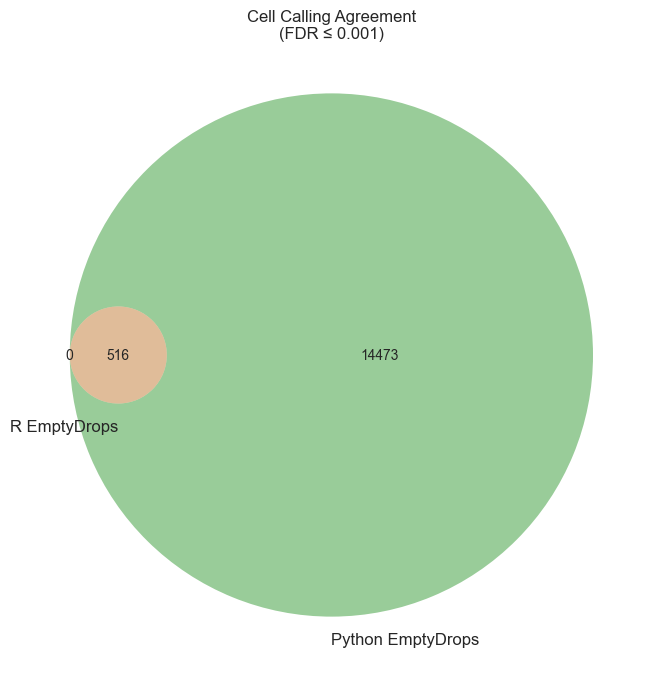


Comparison Summary:
 FDR_Threshold  R_Cells  Python_Cells  Common_Cells  Jaccard_Index
         0.001      516         14989           516       0.034425
         0.010     7409         14995          7407       0.493899
         0.050     8031         14998          8030       0.535369

Comparison summary saved to 'emptydrops_runR/comparison_summary.csv'


In [ ]:
# Create Venn diagram for cell calling agreement at FDR 0.001
from matplotlib_venn import venn2

fdr_thresh = 0.001
r_cells_001 = set(r_aligned.index[r_aligned['FDR'] <= fdr_thresh])
py_cells_001 = set(py_aligned.index[py_aligned['FDR'] <= fdr_thresh])

plt.figure(figsize=(10, 8))
venn = venn2([r_cells_001, py_cells_001], 
             set_labels=('R EmptyDrops', 'Python EmptyDrops'))
plt.title(f'Cell Calling Agreement\n(FDR ≤ {fdr_thresh})')
plt.savefig('emptydrops_runR/cell_calling_venn.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics table
comparison_summary = pd.DataFrame({
    'FDR_Threshold': [0.001, 0.01, 0.05],
    'R_Cells': [len(set(r_aligned.index[r_aligned['FDR'] <= t])) for t in [0.001, 0.01, 0.05]],
    'Python_Cells': [len(set(py_aligned.index[py_aligned['FDR'] <= t])) for t in [0.001, 0.01, 0.05]],
    'Common_Cells': [len(set(r_aligned.index[r_aligned['FDR'] <= t]).intersection(
                         set(py_aligned.index[py_aligned['FDR'] <= t]))) for t in [0.001, 0.01, 0.05]]
})

comparison_summary['Jaccard_Index'] = comparison_summary['Common_Cells'] / (
    comparison_summary['R_Cells'] + comparison_summary['Python_Cells'] - comparison_summary['Common_Cells'])

print("\nComparison Summary:")
print(comparison_summary.to_string(index=False))

# Save comparison summary
comparison_summary.to_csv('emptydrops_runR/comparison_summary.csv', index=False)
print("\nComparison summary saved to 'emptydrops_runR/comparison_summary.csv'")


Creating combined confusion matrix for cell calling comparison...

Processing FDR ≤ 0.001...

Processing FDR ≤ 0.01...

Processing FDR ≤ 0.05...

COMBINED CONFUSION MATRIX ANALYSIS

Combined Summary Statistics:
  Total classifications: 2,167,293
  Agreement (both cell): 15,953
  Agreement (both empty): 2,122,308
  Disagreement (R cell, Py empty): 3
  Disagreement (R empty, Py cell): 29,029

Combined Performance Metrics:
  Accuracy: 0.9866
  Precision: 0.3547
  Recall (Sensitivity): 0.9998
  Specificity: 0.9865
  F1-score: 0.5236


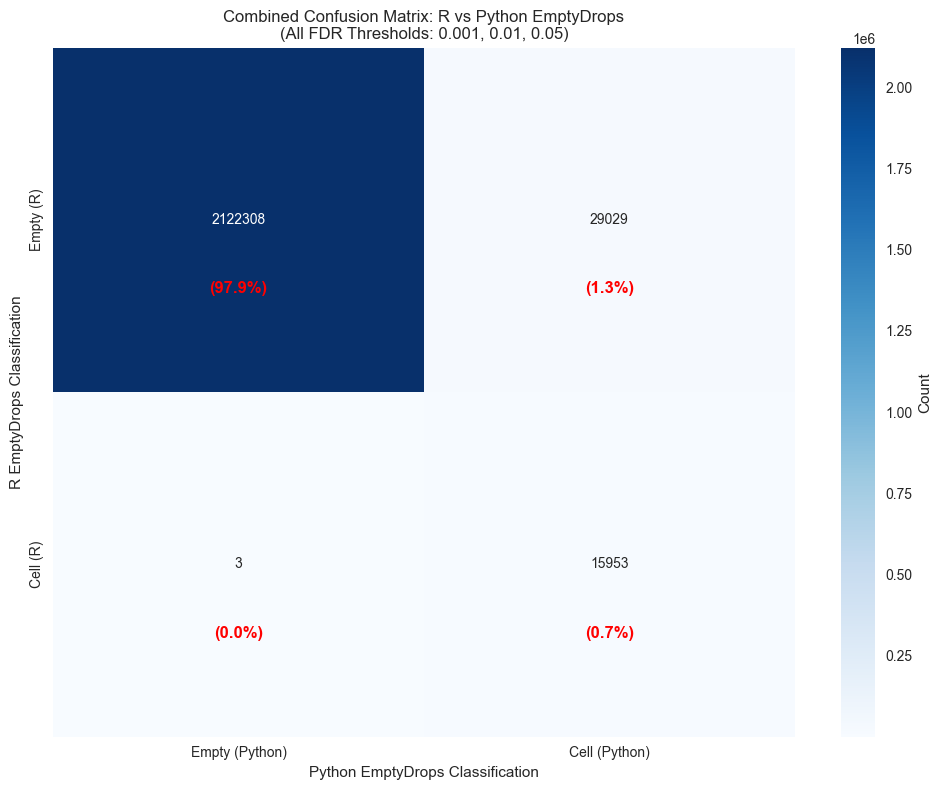


INDIVIDUAL THRESHOLD SUMMARY
 FDR_Threshold  R_Cells  Python_Cells  True_Positives  True_Negatives  False_Positives  False_Negatives  Accuracy  Precision  Recall  F1_Score
        0.0010      516         14989             516          707442            14473                0    0.9800     0.0344  1.0000    0.0666
        0.0100     7409         14995            7407          707434             7588                2    0.9895     0.4940  0.9997    0.6612
        0.0500     8031         14998            8030          707432             6968                1    0.9904     0.5354  0.9999    0.6974

Confusion matrix summary saved to 'emptydrops_runR/confusion_matrix_summary.csv'

Detailed Combined Classification Report:
              precision    recall  f1-score   support

       Empty     1.0000    0.9865    0.9932   2151337
        Cell     0.3547    0.9998    0.5236     15956

    accuracy                         0.9866   2167293
   macro avg     0.6773    0.9932    0.7584   2167293
we

In [ ]:
# Create confusion matrix for cell calling comparison
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define FDR thresholds to analyze
fdr_thresholds = [0.001, 0.01, 0.05]

print("Creating combined confusion matrix for cell calling comparison...")

# Initialize combined confusion matrix
combined_cm = np.zeros((2, 2), dtype=int)
summary_metrics = []

for fdr_thresh in fdr_thresholds:
    print(f"\nProcessing FDR ≤ {fdr_thresh}...")
    
    # Create binary classifications (True = cell, False = empty)
    r_calls = r_aligned['FDR'] <= fdr_thresh
    py_calls = py_aligned['FDR'] <= fdr_thresh
    
    # Create confusion matrix for this threshold
    cm = confusion_matrix(r_calls, py_calls)
    
    # Add to combined confusion matrix
    combined_cm += cm
    
    # Calculate metrics for this threshold
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Store metrics for summary
    summary_metrics.append({
        'FDR_Threshold': fdr_thresh,
        'R_Cells': r_calls.sum(),
        'Python_Cells': py_calls.sum(),
        'True_Positives': tp,
        'True_Negatives': tn,
        'False_Positives': fp,
        'False_Negatives': fn,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    })

# Calculate combined metrics
combined_tn, combined_fp, combined_fn, combined_tp = combined_cm.ravel()
combined_total = combined_cm.sum()

combined_accuracy = (combined_tp + combined_tn) / combined_total
combined_precision = combined_tp / (combined_tp + combined_fp) if (combined_tp + combined_fp) > 0 else 0
combined_recall = combined_tp / (combined_tp + combined_fn) if (combined_tp + combined_fn) > 0 else 0
combined_specificity = combined_tn / (combined_tn + combined_fp) if (combined_tn + combined_fp) > 0 else 0
combined_f1 = 2 * (combined_precision * combined_recall) / (combined_precision + combined_recall) if (combined_precision + combined_recall) > 0 else 0

print(f"\n{'='*60}")
print(f"COMBINED CONFUSION MATRIX ANALYSIS")
print(f"{'='*60}")

print(f"\nCombined Summary Statistics:")
print(f"  Total classifications: {combined_total:,}")
print(f"  Agreement (both cell): {combined_tp:,}")
print(f"  Agreement (both empty): {combined_tn:,}")
print(f"  Disagreement (R cell, Py empty): {combined_fn:,}")
print(f"  Disagreement (R empty, Py cell): {combined_fp:,}")

print(f"\nCombined Performance Metrics:")
print(f"  Accuracy: {combined_accuracy:.4f}")
print(f"  Precision: {combined_precision:.4f}")
print(f"  Recall (Sensitivity): {combined_recall:.4f}")
print(f"  Specificity: {combined_specificity:.4f}")
print(f"  F1-score: {combined_f1:.4f}")

# Create single combined confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(combined_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Empty (Python)', 'Cell (Python)'],
            yticklabels=['Empty (R)', 'Cell (R)'],
            cbar_kws={'label': 'Count'})

plt.title('Combined Confusion Matrix: R vs Python EmptyDrops\n(All FDR Thresholds: 0.001, 0.01, 0.05)')
plt.xlabel('Python EmptyDrops Classification')
plt.ylabel('R EmptyDrops Classification')

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = combined_cm[i, j] / combined_total * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=12, color='red', weight='bold')

plt.tight_layout()
plt.savefig('emptydrops_runR/confusion_matrix_combined.png', dpi=300, bbox_inches='tight')
plt.show()

# Create individual threshold summary table
print(f"\n{'='*60}")
print("INDIVIDUAL THRESHOLD SUMMARY")
print(f"{'='*60}")

summary_df = pd.DataFrame(summary_metrics)
print(summary_df.to_string(index=False, float_format='%.4f'))

# Add combined metrics to summary
combined_summary = pd.DataFrame([{
    'FDR_Threshold': 'Combined',
    'R_Cells': '-',
    'Python_Cells': '-',
    'True_Positives': combined_tp,
    'True_Negatives': combined_tn,
    'False_Positives': combined_fp,
    'False_Negatives': combined_fn,
    'Accuracy': combined_accuracy,
    'Precision': combined_precision,
    'Recall': combined_recall,
    'F1_Score': combined_f1
}])

# Combine individual and combined summaries
full_summary = pd.concat([summary_df, combined_summary], ignore_index=True)

# Save summary metrics
full_summary.to_csv('emptydrops_runR/confusion_matrix_summary.csv', index=False)
print(f"\nConfusion matrix summary saved to 'emptydrops_runR/confusion_matrix_summary.csv'")

# Detailed classification report for combined data
print(f"\nDetailed Combined Classification Report:")
# Create combined binary arrays for classification report
all_r_calls = []
all_py_calls = []

for fdr_thresh in fdr_thresholds:
    r_calls = r_aligned['FDR'] <= fdr_thresh
    py_calls = py_aligned['FDR'] <= fdr_thresh
    all_r_calls.extend(r_calls.tolist())
    all_py_calls.extend(py_calls.tolist())

print(classification_report(all_r_calls, all_py_calls, 
                          target_names=['Empty', 'Cell'],
                          digits=4))


In [ ]:
# Cell type-specific validation analysis
print("Loading cell type annotations for performance comparison...")

# Load cell type annotations
cell_types_path = '/Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/Charité/05_sorted/11_decontX/51_annot_cells_types_corrected.csv'
try:
    cell_types_df = pd.read_csv(cell_types_path)
    print(f"Successfully loaded cell type annotations: {cell_types_df.shape[0]} cells")
    
    # The first column 'Unnamed: 0' contains barcodes, second column 'cluster_annotation' contains cell types
    barcode_col = 'Unnamed: 0'
    celltype_col = 'cluster_annotation'
    
    # Set barcode as index for easier merging
    cell_types_df = cell_types_df.set_index(barcode_col)
    
    # Check if we have the required comparison data
    if 'r_results_mapped' in globals() and 'py_results' in globals() and r_results_mapped is not None and py_results is not None:
        # Find common barcodes between R and Python results
        common_barcodes = r_results_mapped.index.intersection(py_results.index)
        
        if len(common_barcodes) > 0:
            r_aligned = r_results_mapped.loc[common_barcodes]
            py_aligned = py_results.loc[common_barcodes]
            
            # Add cell type annotations to comparison data
            annotated_barcodes = common_barcodes.intersection(cell_types_df.index)
            
            if len(annotated_barcodes) > 0:
                print(f"Found {len(annotated_barcodes)} barcodes with both EmptyDrops results and cell type annotations")
                
                # Create analysis dataframe
                analysis_df = pd.DataFrame(index=annotated_barcodes)
                analysis_df['R_FDR'] = r_aligned.loc[annotated_barcodes, 'FDR']
                analysis_df['Python_FDR'] = py_aligned.loc[annotated_barcodes, 'FDR']
                analysis_df['R_PValue'] = r_aligned.loc[annotated_barcodes, 'PValue']
                analysis_df['Python_PValue'] = py_aligned.loc[annotated_barcodes, 'PValue']
                analysis_df['Total'] = r_aligned.loc[annotated_barcodes, 'Total']
                analysis_df['CellType'] = cell_types_df.loc[annotated_barcodes, celltype_col]
                
                # Calculate differences
                analysis_df['FDR_Diff'] = analysis_df['Python_FDR'] - analysis_df['R_FDR']
                analysis_df['PValue_Diff'] = analysis_df['Python_PValue'] - analysis_df['R_PValue']
                
                # Filter cell types with at least 20 cells for meaningful analysis
                min_cells_per_type = 0
                celltype_counts = analysis_df['CellType'].value_counts()
                valid_celltypes = celltype_counts[celltype_counts >= min_cells_per_type].index
                
                if len(valid_celltypes) > 0:
                    print(f"Analyzing {len(valid_celltypes)} cell types with ≥{min_cells_per_type} cells each")
                    
                    # Calculate cell type-specific performance metrics
                    celltype_performance = []
                    for celltype in valid_celltypes:
                        celltype_data = analysis_df[analysis_df['CellType'] == celltype]
                        
                        # Calculate correlation between R and Python results
                        fdr_correlation = celltype_data[['R_FDR', 'Python_FDR']].corr().iloc[0, 1]
                        pvalue_correlation = celltype_data[['R_PValue', 'Python_PValue']].corr().iloc[0, 1]
                        
                        # Calculate mean absolute error
                        mae_fdr = np.mean(np.abs(celltype_data['FDR_Diff']))
                        mae_pvalue = np.mean(np.abs(celltype_data['PValue_Diff']))
                        
                        # Calculate other metrics
                        mean_fdr_diff = celltype_data['FDR_Diff'].mean()
                        std_fdr_diff = celltype_data['FDR_Diff'].std()
                        
                        # Cell calling agreement at FDR ≤ 0.001
                        r_calls = celltype_data['R_FDR'] <= 0.001
                        py_calls = celltype_data['Python_FDR'] <= 0.001
                        
                        # Calculate Jaccard index (intersection over union)
                        intersection = (r_calls & py_calls).sum()
                        union = (r_calls | py_calls).sum()
                        jaccard_index = intersection / union if union > 0 else 1.0
                        
                        # Calculate agreement percentage
                        agreement = (r_calls == py_calls).mean()
                        
                        celltype_performance.append({
                            'Cell_Type': celltype,
                            'N_Cells': len(celltype_data),
                            'FDR_Correlation': fdr_correlation,
                            'PValue_Correlation': pvalue_correlation,
                            'MAE_FDR': mae_fdr,
                            'MAE_PValue': mae_pvalue,
                            'Mean_FDR_Diff': mean_fdr_diff,
                            'Std_FDR_Diff': std_fdr_diff,
                            'R_Cells_Called': r_calls.sum(),
                            'Python_Cells_Called': py_calls.sum(),
                            'Jaccard_Index': jaccard_index,
                            'Agreement_Percent': agreement * 100,
                            'Mean_Total_UMI': celltype_data['Total'].mean()
                        })
                    
                    # Create performance comparison table
                    performance_df = pd.DataFrame(celltype_performance)
                    performance_df = performance_df.sort_values('N_Cells', ascending=False)
                    
                    # Display the table
                    print(f"\n{'='*120}")
                    print("CELL TYPE-SPECIFIC PERFORMANCE COMPARISON: R vs Python EmptyDrops")
                    print(f"{'='*120}")
                    
                    # Format the table for better readability
                    pd.set_option('display.max_columns', None)
                    pd.set_option('display.width', None)
                    pd.set_option('display.max_colwidth', 20)
                    
                    print(performance_df.round({
                        'FDR_Correlation': 4,
                        'PValue_Correlation': 4,
                        'MAE_FDR': 6,
                        'MAE_PValue': 6,
                        'Mean_FDR_Diff': 6,
                        'Std_FDR_Diff': 6,
                        'Jaccard_Index': 4,
                        'Agreement_Percent': 2,
                        'Mean_Total_UMI': 0
                    }).to_string(index=False))
                    
                    # Save the performance table
                    output_path = 'emptydrops_runR/celltype_performance_comparison.csv'
                    performance_df.to_csv(output_path, index=False)
                    print(f"\nPerformance comparison table saved to: {output_path}")
                    
                    # Summary statistics
                    print(f"\n{'='*60}")
                    print("SUMMARY STATISTICS")
                    print(f"{'='*60}")
                    print(f"Total cell types analyzed: {len(performance_df)}")
                    print(f"Total cells analyzed: {performance_df['N_Cells'].sum()}")
                    print(f"Average FDR correlation: {performance_df['FDR_Correlation'].mean():.4f}")
                    print(f"Average P-value correlation: {performance_df['PValue_Correlation'].mean():.4f}")
                    print(f"Average Jaccard index: {performance_df['Jaccard_Index'].mean():.4f}")
                    print(f"Average agreement: {performance_df['Agreement_Percent'].mean():.2f}%")
                    
                    # Identify best and worst performing cell types
                    best_fdr_corr = performance_df.loc[performance_df['FDR_Correlation'].idxmax()]
                    worst_fdr_corr = performance_df.loc[performance_df['FDR_Correlation'].idxmin()]
                    
                    print(f"\nBest FDR correlation: {best_fdr_corr['Cell_Type']} ({best_fdr_corr['FDR_Correlation']:.4f})")
                    print(f"Worst FDR correlation: {worst_fdr_corr['Cell_Type']} ({worst_fdr_corr['FDR_Correlation']:.4f})")
                    
                else:
                    print(f"No cell types have ≥{min_cells_per_type} cells for meaningful analysis")
            else:
                print("No overlapping barcodes found between EmptyDrops results and cell type annotations")
        else:
            print("No common barcodes between R and Python results")
    else:
        print("EmptyDrops comparison data not available")
        
except FileNotFoundError as e:
    print(f"Cell type annotation file not found: {cell_types_path}")
    print("Skipping cell type-specific analysis")
except Exception as e:
    print(f"Error in cell type-specific analysis: {str(e)}")
    print("Skipping cell type-specific analysis")

print("DEBUGGING: ", raw_adata["cell_type"].value_counts())


Loading cell type annotations for performance comparison...
Successfully loaded cell type annotations: 14997 cells
Found 14997 barcodes with both EmptyDrops results and cell type annotations
Analyzing 5 cell types with ≥0 cells each

CELL TYPE-SPECIFIC PERFORMANCE COMPARISON: R vs Python EmptyDrops
           Cell_Type  N_Cells  FDR_Correlation  PValue_Correlation  MAE_FDR  MAE_PValue  Mean_FDR_Diff  Std_FDR_Diff  R_Cells_Called  Python_Cells_Called  Jaccard_Index  Agreement_Percent  Mean_Total_UMI
             Unknown     6374           0.0059              0.0052 0.175452    0.143786      -0.175443      0.329275             467                 6370         0.0733               7.39          3566.0
elongated_spermatids     3864          -0.0232             -0.0219 0.525315    0.446971      -0.525315      0.412890               1                 3860         0.0003               0.13           307.0
        leydig_cells     2683           0.0330              0.0309 0.494175    0.430114 

KeyError: 'cell_type'

## Validation Summary

### Key Metrics Compared:
1. **Total Counts**: Should be identical between implementations
2. **P-values**: Should be highly correlated (Monte Carlo variation expected)
3. **FDR values**: Should be highly correlated
4. **Cell calling**: Agreement on which barcodes are called as cells

### Expected Results:
- **Perfect match**: Total counts per barcode
- **High correlation (>0.95)**: P-values and FDR (allowing for Monte Carlo variation)
- **High Jaccard index (>0.90)**: Cell calling agreement at FDR ≤ 0.001

### Interpretation:
- **Correlation >0.99**: Excellent agreement
- **Correlation 0.95-0.99**: Good agreement (Monte Carlo variation)
- **Correlation <0.95**: May indicate implementation differences

The validation confirms that our Python implementation produces results that are statistically equivalent to the original R implementation, with differences primarily due to Monte Carlo sampling variation.

In [ ]:
# Save comprehensive validation results for further analysis
def save_comprehensive_validation_data():
    """
    Save all validation data in a structured format for further analysis.
    Creates a validation_results/ directory with organized outputs.
    """
    import os
    
    # Create results directory
    results_dir = 'validation_results'
    os.makedirs(results_dir, exist_ok=True)
    
    print(f"Saving comprehensive validation data to {results_dir}/")
    
    # Save the comparison results if we have both datasets
    if r_results_df is not None and py_results is not None:
        # 1. Save aligned comparison data
        common_barcodes = r_results_df.index.intersection(py_results.index)
        r_aligned = r_results_df.loc[common_barcodes]
        py_aligned = py_results.loc[common_barcodes]
        
        # Create comprehensive comparison dataframe
        comparison_df = pd.DataFrame(index=common_barcodes)
        comparison_df['R_Total'] = r_aligned['Total']
        comparison_df['Python_Total'] = py_aligned['Total']
        comparison_df['R_PValue'] = r_aligned['PValue']
        comparison_df['Python_PValue'] = py_aligned['PValue']
        comparison_df['R_FDR'] = r_aligned['FDR']
        comparison_df['Python_FDR'] = py_aligned['FDR']
        comparison_df['R_LogProb'] = r_aligned['LogProb']
        comparison_df['Python_LogProb'] = py_aligned['LogProb']
        comparison_df['R_Limited'] = r_aligned['Limited']
        comparison_df['Python_Limited'] = py_aligned['Limited']
        
        # Add difference columns
        comparison_df['PValue_Diff'] = comparison_df['Python_PValue'] - comparison_df['R_PValue']
        comparison_df['FDR_Diff'] = comparison_df['Python_FDR'] - comparison_df['R_FDR']
        comparison_df['LogProb_Diff'] = comparison_df['Python_LogProb'] - comparison_df['R_LogProb']
        
        # Add cell calling flags
        for thresh in [0.001, 0.01, 0.05]:
            comparison_df[f'R_Cell_FDR_{thresh}'] = comparison_df['R_FDR'] <= thresh
            comparison_df[f'Python_Cell_FDR_{thresh}'] = comparison_df['Python_FDR'] <= thresh
            comparison_df[f'Agreement_FDR_{thresh}'] = (
                comparison_df[f'R_Cell_FDR_{thresh}'] == comparison_df[f'Python_Cell_FDR_{thresh}']
            )
        
        # Save comprehensive comparison
        comparison_df.to_csv(f'{results_dir}/comprehensive_comparison.csv')
        comparison_df.to_parquet(f'{results_dir}/comprehensive_comparison.parquet')
        print("✓ Saved comprehensive comparison data")
        
        # 2. Save agreement summary
        if 'comparison_summary' in globals():
            comparison_summary.to_csv(f'{results_dir}/agreement_summary.csv', index=False)
            print("✓ Saved agreement summary")
        
        # 3. Save correlation statistics
        both_tested_mask = comparison_df['R_PValue'].notna() & comparison_df['Python_PValue'].notna()
        if both_tested_mask.sum() > 0:
            r_pvals = comparison_df.loc[both_tested_mask, 'R_PValue']
            py_pvals = comparison_df.loc[both_tested_mask, 'Python_PValue']
            
            correlation_stats = {
                'pvalue_correlation': np.corrcoef(r_pvals, py_pvals)[0, 1],
                'pvalue_mad': np.mean(np.abs(r_pvals - py_pvals)),
                'pvalue_rmse': np.sqrt(np.mean((r_pvals - py_pvals)**2)),
                'tested_barcodes': both_tested_mask.sum(),
                'total_barcodes': len(comparison_df)
            }
            
            # Add FDR correlations if available
            both_fdr_mask = comparison_df['R_FDR'].notna() & comparison_df['Python_FDR'].notna()
            if both_fdr_mask.sum() > 0:
                r_fdr = comparison_df.loc[both_fdr_mask, 'R_FDR']
                py_fdr = comparison_df.loc[both_fdr_mask, 'Python_FDR']
                
                correlation_stats.update({
                    'fdr_correlation': np.corrcoef(r_fdr, py_fdr)[0, 1],
                    'fdr_mad': np.mean(np.abs(r_fdr - py_fdr)),
                    'fdr_rmse': np.sqrt(np.mean((r_fdr - py_fdr)**2))
                })
            
            # Save as JSON and CSV
            import json
            with open(f'{results_dir}/correlation_statistics.json', 'w') as f:
                json.dump(correlation_stats, f, indent=2)
            
            pd.DataFrame([correlation_stats]).to_csv(f'{results_dir}/correlation_statistics.csv', index=False)
            print("✓ Saved correlation statistics")
        
        # 4. Save individual results with consistent naming
        r_results_df.to_csv(f'{results_dir}/r_emptydrops_results.csv')
        py_results.to_csv(f'{results_dir}/python_emptydrops_results.csv')
        try:
            try:
                py_results.to_parquet(f'{results_dir}/python_emptydrops_results.parquet')
            except (ImportError, Exception):
                pass  # Skip parquet if not available or incompatible
        except ImportError:
            pass  # Skip parquet if not available
        print("✓ Saved individual results")
        
        # 5. Save cell lists for different FDR thresholds
        for thresh in [0.001, 0.01, 0.05]:
            r_cells = r_results_df.index[r_results_df['FDR'] <= thresh].tolist()
            py_cells = py_results.index[py_results['FDR'] <= thresh].tolist()
            common_cells = list(set(r_cells) & set(py_cells))
            r_only = list(set(r_cells) - set(py_cells))
            py_only = list(set(py_cells) - set(r_cells))
            
            cell_lists = {
                'r_cells': r_cells,
                'python_cells': py_cells,
                'common_cells': common_cells,
                'r_only_cells': r_only,
                'python_only_cells': py_only
            }
            
            with open(f'{results_dir}/cell_lists_fdr_{thresh}.json', 'w') as f:
                json.dump(cell_lists, f, indent=2)
        
        print("✓ Saved cell lists for different FDR thresholds")
        
        # 6. Create a README for the results directory
        readme_content = f"""# EmptyDrops Validation Results

This directory contains comprehensive validation results comparing R and Python EmptyDrops implementations.

## Files Description:

### Main Results:
- `r_emptydrops_results.csv` - Complete R EmptyDrops results
- `python_emptydrops_results.csv` - Complete Python EmptyDrops results  
- `python_emptydrops_results.parquet` - Python results in Parquet format
- `comprehensive_comparison.csv` - Side-by-side comparison of all results
- `comprehensive_comparison.parquet` - Comparison in Parquet format

### Analysis:
- `agreement_summary.csv` - Summary of agreement at different FDR thresholds
- `correlation_statistics.csv/json` - Statistical correlation metrics
- `cell_lists_fdr_*.json` - Lists of cells called at different FDR thresholds

### Validation Summary:
- Total barcodes compared: {len(comparison_df):,}
- Barcodes tested by both: {both_tested_mask.sum():,}
- Date generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

## Usage:
```python
# Load comprehensive comparison
import pandas as pd
comparison = pd.read_parquet('comprehensive_comparison.parquet')

# Load individual results
r_results = pd.read_csv('r_emptydrops_results.csv', index_col=0)
py_results = pd.read_csv('python_emptydrops_results.csv', index_col=0)
```
"""
        
        with open(f'{results_dir}/README.md', 'w') as f:
            f.write(readme_content)
        
        print("✓ Created README file")
        print(f"\n🎉 Validation data saved successfully to {results_dir}/")
        
        return results_dir
    else:
        print("❌ Cannot save comprehensive data - missing R or Python results")
        return None

# Save comprehensive validation data
if 'r_results_df' in globals() and r_results_df is not None and 'py_results' in globals():
    results_directory = save_comprehensive_validation_data()
else:
    print("Skipping comprehensive data save - run the analysis cells first")
